# connectLib Pipeline Algorithm

## Introduction
The connectLib Pipeline filters out the background noise of an n-dimensional image and then segments the resulting image into groups of data type Cluster presented in list-form. The pipeline uses Otsu's Binarization to filter out the background noise. Next, Connected Components clusters the remaining foreground. We then remove outlier clusters using the Interquartile Range Rule. These outliers result from the filtered background which gets labeled as one large cluster. The final step is to coregister our clusters with the raw image. This is a consequence from the PLOS Pipeline (see PLOS_Pipeline_Revised.md) which degrades the original clusters.

## Simulation Data

### Easy Simulation:
Our simulated data will be a 100x100x100 volume with a pixel intensity distribution approximately the same as that of the true image volumes (i.e., 98% noise, 2% synapse). The synapse pixels will be grouped together in clusters as they would in the true data. Based on research into the true size of synapses, these synthetic synapse clusters will be given area of ~.2 microns ^3, or about 27 voxels (assuming the synthetic data here and the real world data have identical resolutions). We will differeniate the background from the foreground in this simulation by assigning intensity values. Background pixels will be assigned a value from 0-10,000; foreground points will be given a value of 60,000. After the data goes through the pipeLine, I will gauge performance based on the following:

1. average volume of synapses (should be about 27 voxels) 
2. volumetric density of data (should be about 2% of the data)

We believe our pipeline will yield perfect results on this simulated data. This is because the main filtering from Otsu's Binarization requires the distribution of pixel values to be bimodal. That is, there is a clear differentiation between background and foreground. 


### Easy Simulation Code

In [ ]:
import sys
sys.path.insert(0,'../code/functions/')
from random import randrange as rand
from skimage.measure import label
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 2):
        for y in range(-1, 2):
            for x in range(-1, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume

randIm = generateTestVolume()
foreground = randIm[0]
combinedIm = randIm[1]

**What We Expect Our Simulation Data Will Look Like:**
The above code should generate a 100x100x100 volume and populate it with various, non-intersectting pointsets (representing foreground synpases). When the foreground is generated, the volume will then be introduced to random background noise which will fill the rest of the volume. 

### Easy Simulation Plots

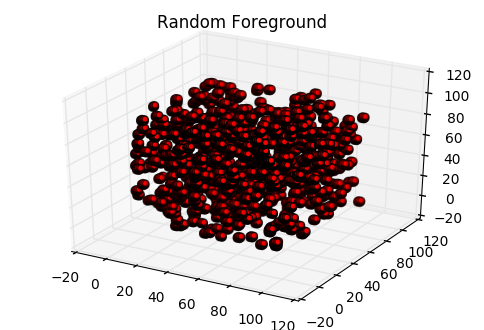

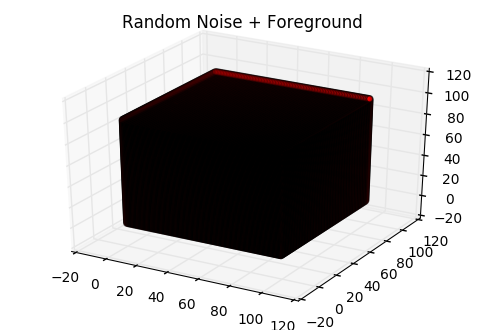

In [3]:
#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foreground.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground')
plt.show()

#displaying the noise
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = combinedIm.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Noise + Foreground')
plt.show()

**Why Our Simulation is Correct:** Real microscopic images of synapses usually contain a majority of background noise and relatively few synapse clusters. As shown above, the generated test volume follows this expectation. 

## Difficult Simulation
We will now simulate data where our algorithm will not perform well on. We will generate a 20x20x20 test volume populated with background and foreground pixels containing the same intensity. Since the distribution of pixels is now unimodal (no clear difference between background and foreground), our filtering algorithm should not work well.

### Difficult Simulation Code and Plot

In [11]:
all100Dat = pickle.load(open('../code/tests/synthDat/all100.synth'))

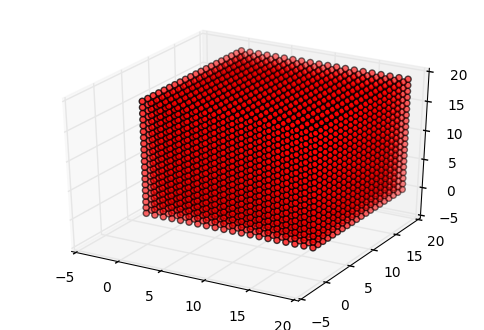

In [12]:
#The uniform data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = all100Dat.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

# Simulation Analysis

## Pseudocode
####################################################
###PSEUDOCODE WILL GO HERE ONCE I FIGURE OUT HOW####
####################################################

In [6]:
from skimage.filters import threshold_otsu
from skimage.measure import label
from cluster import Cluster
import numpy as np
import cv2
import plosLib as pLib

### Step 1: Threshold the image using Otsu Binarization 
def otsuVox(argVox):
    probVox = np.nan_to_num(argVox)
    bianVox = np.zeros_like(probVox)
    for zIndex, curSlice in enumerate(probVox):
        #if the array contains all the same values
        if np.max(curSlice) == np.min(curSlice):
            #otsu thresh will fail here, leave bianVox as all 0's
            continue
        thresh = threshold_otsu(curSlice)
        bianVox[zIndex] = curSlice > thresh
    return bianVox

### Step 2: Cluster foreground using Connected Components
def connectedComponents(voxel):
    labelMap = label(voxel)
    clusterList = []
    #plus 1 since max label should be included
    for uniqueLabel in range(0, np.max(labelMap)+1):
        memberList = [list(elem) for elem in zip(*np.where(labelMap == uniqueLabel))]
        if not len(memberList) == 0:
            clusterList.append(Cluster(memberList))
    return clusterList

### Step 3: Remove outlier clusters using IRQ Rule
def thresholdByVolumePercentile(clusterList):
    #putting the plosPipeline clusters volumes in a list
    plosClusterVolList =[]
    for cluster in (range(len(clusterList))):
        plosClusterVolList.append(clusterList[cluster].getVolume())

    #finding the upper outlier fence
    Q3 = np.percentile(plosClusterVolList, 75)
    Q1 = np.percentile(plosClusterVolList, 25)
    IQR = Q3 - Q1
    upperThreshFence = Q3 + 1.5*IQR
    lowerThreshFence = Q1 - 1.5*IQR

    #filtering out the background cluster
    upperThreshClusterList = []
    for cluster in (range(len(clusterList))):
        if clusterList[cluster].getVolume() < upperThreshFence and clusterList[cluster].getVolume() > lowerThreshFence:
            upperThreshClusterList.append(clusterList[cluster])

    return upperThreshClusterList

### Step 4: Coregister clusters with raw data.
def clusterCoregister(plosClusterList, rawClusterList):
    #creating a list of all the member indices of the plos cluster list
    plosClusterMemberList = []
    for cluster in range(len(plosClusterList)):
        plosClusterMemberList.extend(plosClusterList[cluster].members)

    #creating a list of all the clusters without any decay
    finalClusterList =[]
    for rawCluster in range(len(rawClusterList)):
        for index in range(len(plosClusterMemberList)):
            if ((plosClusterMemberList[index] in rawClusterList[rawCluster].members) and (not(rawClusterList[rawCluster] in finalClusterList))):
                finalClusterList.append(rawClusterList[rawCluster])

    return finalClusterList

## Easy Simulation Analysis
**What We Expect**
As previously mentioned, we believe the pipeline will work very well on the easy simulation (See Simulation Data: Easy Simulation for explanation).

**Generate Easy Simulation Data:** See Simulation Data Above.

### Algorithm Run on Easy Data

In [8]:
#Plos Pipeline Results
plosOut = pLib.pipeline(combinedIm)
#Otsu's Binarization Thresholding
bianOut = otsuVox(plosOut)
#Connected Components
connectList = connectedComponents(bianOut)
#Remove outlier clusters
threshClusterList = thresholdByVolumePercentile(connectList)
#finding the clusters without plosPipeline - lists the entire clusters
bianRawOut = otsuVox(combinedIm)
clusterRawList = connectedComponents(bianRawOut)
#coregistering with raw data
completeClusterMemberList = clusterCoregister(threshClusterList, clusterRawList)

### Results 

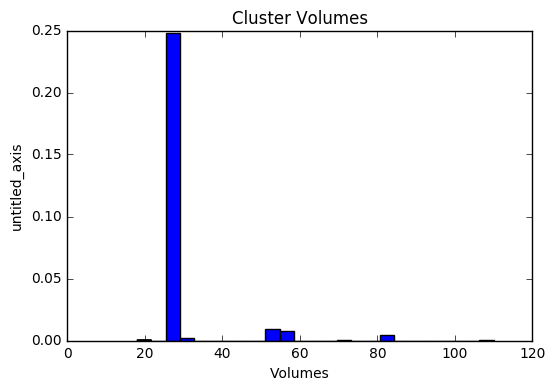

In [14]:
import mouseVis as mv

#plotting results
completeClusterVolumes = []
for cluster in completeClusterMemberList:
    completeClusterVolumes.append(cluster.getVolume())
mv.generateHist(completeClusterVolumes, title = 'Cluster Volumes', bins = 25, xaxis = 'Volumes')


In [ ]:

#test stats
#average volume of detected clusters
avgClusterVol = np.mean(completeClusterVolumes)
#average volume of total foreground clusters
foregroundClusterList = cLib.connectedComponents(foreground)

del foregroundClusterList[0] #background cluster
foregroundClusterVols = []
for cluster in foregroundClusterList:
    foregroundClusterVols.append(cluster.getVolume())
avgActualVol = np.mean(foregroundClusterVols)

print 'Easy Simulation: Mean Volume'
print "\tExpected: " + str(avgActualVol) + '\tActual: ' + str(avgClusterVol)


print 'Easy Simulation: Cluster Density of Data By Volume'
print "\tExpected: " + str(np.sum(foregroundClusterVols)/(100*100*100.0)) + '\tActual: ' + str(np.sum(completeClusterVolumes)/(100*100*100.0))